In [10]:
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import h5py
from astropy import constants as const
import seaborn as sns
import numpy as np
from math import pi
import matplotlib



In [11]:
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['axes.labelsize'] = 24
matplotlib.rcParams['xtick.labelsize'] = 30
matplotlib.rcParams['ytick.labelsize'] = 30
matplotlib.rcParams['xtick.major.size'] = 20
matplotlib.rcParams['ytick.major.size'] = 20
matplotlib.rcParams['xtick.top'] = True
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['xtick.minor.visible'] = True
matplotlib.rcParams['xtick.minor.size'] = 10
matplotlib.rcParams['ytick.minor.size'] = 10
matplotlib.rcParams['legend.fontsize'] = 18
matplotlib.rcParams['legend.frameon'] = True
matplotlib.rcParams['lines.linewidth'] = 3

# Plot waveforms 

Read in the waveforms and plot 

### Read in the extrapolated waveforms

In [2]:
def swsh(s, modes, theta, phi, psi=0):
    """
    Return a value of a spin-weighted spherical harmonic of spin-weight s. 
    If passed a list of several modes, then a numpy array is returned with 
    SWSH values of each mode for the given point.
    For one mode:       swsh(s,[(l,m)],theta,phi,psi=0)
    For several modes:  swsh(s,[(l1,m1),(l2,m2),(l3,m3),...],theta,phi,psi=0)
    """
    import spherical_functions as sf
    import quaternion as qt
    return sf.SWSH(qt.from_spherical_coords(theta, phi), s, modes) * np.exp(1j * s * psi)


## Read in the extrapolated modes
def ReadExtrapolatedModes(file, mass_msun, dist_kpc, theta, phi):
    """ 
        File is the file containing the extrapolated waveform that we want to read in 
        mass_msun is the total mass of the system in solar masses, and 
        dist_kpc is the distance to the system in kpc. 
        theta and phi are angles determining the inclination.
    """

    ## Read in the data
    f = h5py.File(file, 'r')
    
    ## grab the length of the waveform first
    data = f['Extrapolated_N2.dir']['Y_l2_m2.dat']
    time = np.array(data[:,0])
    
    h_plus = np.zeros(len(time))
    h_cross = np.zeros(len(time))
    
    modes = [(l,m) for l in range(2,5) for m in range(-l, l+1)]
    for mode in modes: 
        
        ## Grab the mode in question
        #print('Computing for ', mode)
        l = mode[0]
        m = mode[1]
        
        data = f['Extrapolated_N2.dir']['Y_l' + str(l) + '_m' + str(m) + '.dat']
        real = np.array(data[:,1])
        imag = np.array(data[:,2])
        coeff = real + 1j * imag
        
        ## Multiply by the corresponding spin-weighted spherical harmonic
        Ylm = swsh(-2, [(l,m)], theta=theta, phi=phi, psi=0) 
        h = coeff * Ylm 
        
        ## Add to our h_plus and h_cross computations
        h_plus = h_plus + np.real(h)
        h_cross = h_cross - np.imag(h) 
        
        
    ## Apply the astrophysical parameters
    time = time*mass_msun*const.G/(const.c**3)
    h_plus = h_plus*const.G*mass_msun/((const.c)**2*dist_kpc)
    h_cross = h_cross*const.G*mass_msun/((const.c)**2*dist_kpc)
    
    ## Now subtract off the peak time (this makes the spine interpolation easier)
    amp = np.sqrt(h_plus**2 + h_cross**2)
    time = time - time[np.argmax(amp)]

    return time, h_plus, h_cross

    

### Astrophysical parameters

In [5]:
## Masses, distances, and sample rates
dist_mpc = 400
dist_kpc = dist_mpc * 1000 * const.kpc
mass = 68
mass_msun = mass * const.M_sun

## Inclination angle
theta = pi
phi = 0


### Compute the waveforms we want

In [6]:
## NR waveforms

time, h_plus, h_cross = ReadExtrapolatedModes('Waveforms/Lev2/dCS_Strain_0p0.h5', \
                                                 mass_msun, dist_kpc, theta, phi)

### Plot all of the waveforms together

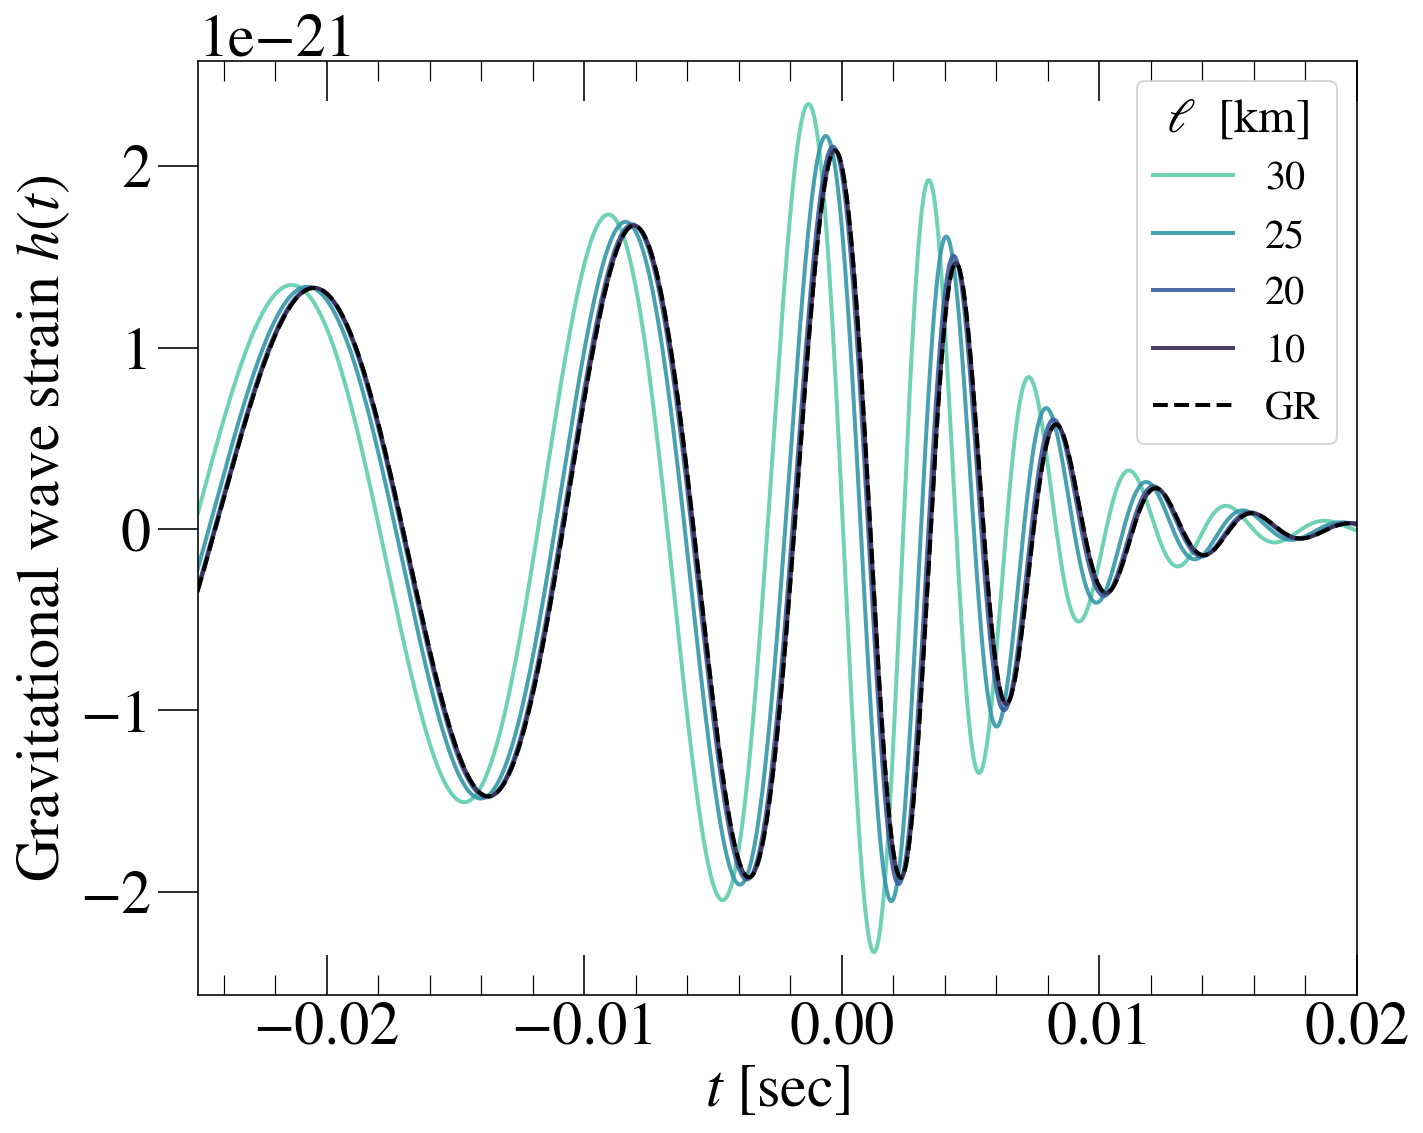

In [35]:
plt.figure(figsize=(10, 8))

#ell_arr = [0.1, 0.2, 0.25, 0.3]
ell_arr = [0.3, 0.25, 0.2, 0.1]
cs = sns.color_palette('mako_r', n_colors=len(ell_arr))

for ell, c in zip(ell_arr, cs):
    
    name = str(ell).replace('.', 'p')
    file = 'Waveforms/Lev2/dCS_Strain_' + name + '.h5'
    
    ## Get physical value for ell 
    phys_ell_km = ell * mass_msun * const.G /(const.c**2) / 1000

    time, h_plus, h_cross = ReadExtrapolatedModes(file, mass_msun, dist_kpc, theta, phi)
    plt.plot(time, h_plus, lw=2.0, label=int(phys_ell_km.value), color=c, alpha=0.9)

time, h_plus, h_cross = ReadExtrapolatedModes('Waveforms/Lev2/BackgroundStrain.h5', mass_msun, dist_kpc, theta, phi)
plt.plot(time, h_plus, lw=2.0, ls='--', label='GR', color='black')
    
plt.xlim(-0.025, 0.02)
#plt.ylim(1.5e-21, 2.5e-21)
plt.xlabel('$t$ [sec]', fontsize=30)
plt.ylabel('Gravitational wave strain $h(t)$', fontsize=30)
legend = plt.legend(title='$\ell$  [km]', fontsize=20)
plt.setp(legend.get_title(),fontsize=24)
#plt.grid()
plt.tight_layout()
plt.savefig('dCSWaveforms.pdf')
plt.show()
